In [44]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.sparse.linalg.eigen.arpack as arp



from tenpy.models.model import CouplingModel, MPOModel
from tenpy.models.lattice import Chain
from tenpy.networks.site import BosonSite
from tenpy.networks.mps import MPS
from tenpy.tools.params import asConfig
from tenpy.linalg import np_conserved as npc
from tenpy.linalg.np_conserved import svd
from tenpy.linalg.lanczos import LanczosGroundState
from tenpy.linalg.sparse import NpcLinearOperator

### MPO Hamiltonian

In [194]:
class HardCoreBosonModel(CouplingModel,MPOModel):
    
    def __init__(self, model_params):
    
        # 0) read out/set default parameters
        model_params = asConfig(model_params, "BoseModel")
        
        L = model_params.get('L', 12)                 #length of the chain
        t = np.asarray(model_params.get('t', 1.))     #tunnelling rate
        rc = model_params.get('rc', 1.)               #range of soft-shoulder interaction
        V = np.asarray(model_params.get('V', 1.))     # soft-shoulder interaction
        bc_MPS = model_params.get('bc_MPS', 'finite') #boundary condition of MPS
        filling = model_params.get('filling', 0.5)    #average site filling 
        n_max = model_params.get('n_max', 1)          #max number of bosons per site
        conserve = model_params.get('conserve', 'N')  
        
        
        # 3) local physical site
        self.site = BosonSite(Nmax=n_max, conserve=conserve, filling=filling)
        
        # 4) lattice #ARE THESE PARAMETERS OK?
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        self.lat = Chain(L, self.site, bc=bc, bc_MPS=bc_MPS)
        
        # 5) initialize CouplingModel
        CouplingModel.__init__(self, self.lat)
        
        
        # 6) add terms of the Hamiltonian
        
        #NEAREST NEIGHBOR INTERACTION 
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-t, u1, 'Bd', u2, 'B', dx, plus_hc=True)
            
        #SOFT SHOULDER INTERACTION
        for int_range in range(2,rc+1):
            (u1, u2, dx) = self.lat.find_coupling_pairs(max_dx=L, cutoff=rc).get(int_range)[0]
            self.add_coupling(V, u1, 'N', u2, 'N', dx, plus_hc=False)
        
        # 7) initialize H_MPO
        MPOModel.__init__(self, self.lat, self.calc_H_MPO())
    

### RP

#### Initialize trivial identity, store it in RPs and calculate all the others accordingly

In [195]:
def trivial_RP(psi, model, verbose):
    
    #control variable
    check = verbose.get('trivial_RP')
    
    if check:print("Begin building RP_Id\n")
    
    #build trivial Identity
    r"""

    vL -->--
            |
            |
    wL -->--RP_Id
            |  
            |
    vL*--<--

    """

    # create a ChargeInfo to specify the nature of the charge
    chinfo = npc.ChargeInfo([1], ['N'])  

    #vL
    vL_charge = psi.get_B(model_params.get('L')-1).get_leg('vR').charges
    vL_leg = npc.LegCharge.from_qflat(chinfo, vL_charge,+1)  

    #wL
    wL_charge = model.H_MPO.get_W(model_params.get('L')-1).get_leg('wR').charges
    wL_leg = npc.LegCharge.from_qflat(chinfo, wL_charge,+1) 


    #initialize ones tensor
    RP_Id = npc.ones([vL_leg, wL_leg, vL_leg.conj()],
                   labels=['vL', 'wL', 'vL*'])
    
    if check:
        print("RP_Id:\n",RP_Id)
        print("-"*20)
    
    return RP_Id
    

In [196]:
#function to calculate all the RPs
def update_RP(i, RPs, psi, model, verbose):#theta [i-1,i], RP[i+1]
    
    #control variable
    check = verbose.get('update_RP')
    
    if check:print("Begin updating RPs\n")
    
    #store previous RP
    if i==(model_params.get('L')-1): #last element
        RP = trivial_RP(psi, model,verbose)
    else:
        RP = RPs[i+1]
    
    #MPS term
    r"""

    vL-->--B-->vR
           |
           ^
           |
           p
    """
    B = psi.get_B(i) #vL p vR
    if check:print("MPS term B:\n",B)
    
    #complex conj MPS term
    r"""
             p*
             |
             ^
             |
    vL* --<--Bc--<--vR*
    """
    Bc = B.conj() #vL* p* vR*
    if check:print("MPS conj term Bc:\n",Bc)
        
    #MPO term
    r"""

            p*
            |
            ^
            |
    wL -->--W-->--wR
            |
            ^
            |
            p


    """
    W = model.H_MPO.get_W(i) #wL wR p p*
    if check:print("MPO term W:\n", W)
        
    
    #contractions
    
    RP = npc.tensordot(B, RP, axes=['vR','vL']) #vL p [vR], [vL] wL vL*
    if check:print("Contraction B[vR]<->RP[vL]:\n",RP)
        
    RP = npc.tensordot(RP, W, axes=[['p','wL'],['p*','wR']]) #vL [p] [wL] vL*, wL [wR] p [p*]
    if check:print("Contraction RP[p,wL]<->W[p*,wR]:\n", RP)
        
    RP = npc.tensordot(RP, Bc, axes=[['p','vL*'],['p*','vR*']]) #vL [vL*] wL [p],vL* [p*] [vR*]
    if check:print("Contraction RP[p,vL*]<->Bc[p*,vR*]:\n", RP)
        
    r"""
    
    
    vL-->--B
           |
           ^
           |
    wL-->--W     
           |
           ^
           |
   vL*--<--Bc
    
    
    
    """
    
    if check:
        print("End updating RPs")
        print("-"*20)
        
    return RP


In [197]:
def compute_RPs(j, psi, model, model_params, verbose): 
    
    #control variable
    check = verbose.get('compute_RPs')
    
    if check:print("Begin computing all RPs\n")
    
    #empty list of RPs
    RPs = [None]*model_params.get('L')
    if check:print("Initial RPs:\n",RPs)
    
    #calculate al the other RPs
    for i in range(model_params.get('L')-1,j,-1):  #RPs up to index j+1 COMPRESO
        RP = update_RP(i, RPs, psi, model,verbose)
        RPs[i] = RP
        
    if check:
        print("Final RPs:\n",RPs)
        print("-"*20)
        
        
    return RPs



### LP

#### Initialize trivial identity, store it in RPs and calculate all the others accordingly

In [198]:
def trivial_LP(psi, model, verbose):
    
    #control variable
    check = verbose.get('trivial_LP')
    
    if check:print("Begin building LP_Id\n")
    
    #build trivial zero
    r"""

             -->-- vR
            |
            |
        RP_Id-->--wR
            |  
            |
             --<--vR*

    """

    # create a ChargeInfo to specify the nature of the charge
    chinfo = npc.ChargeInfo([1], ['N'])  

    #Legs
    vR_charge = psi.get_B(0).get_leg('vL').charges
    vR_leg = npc.LegCharge.from_qflat(chinfo, vR_charge,-1) 

    wR_charge = model.H_MPO.get_W(0).get_leg('wL').charges
    wR_leg = npc.LegCharge.from_qflat(chinfo, wR_charge,-1) 


    LP_Id = npc.ones([vR_leg, wR_leg, vR_leg.conj()],
                   labels=['vR', 'wR', 'vR*'])
    
    if check:
        print("LP_Id:\n", LP_Id)
        print("-"*20)
    
    return LP_Id

In [199]:
#function to calculate all the LPs
def update_LP(i, LPs, psi, model, verbose): #up to site [i,i+1], LP[i-1]
    
    #control variable
    check = verbose.get('update_LP')
    
    if check:print("Begin updating LPs\n")
    
    #store previous RP
    if i==0: #first element
        LP = trivial_LP(psi, model,verbose)
    else:
        LP = LPs[i-1]
    
    #MPS term
    r"""

    vL-->--B-->vR
           |
           ^
           |
           p
    """
    B = psi.get_B(i) #vL p vR
    if check:print("MPS term B:\n", B)
    
    #complex conj MPS term
    r"""
             p*
             |
             ^
             |
    vL* --<--Bc--<--vR*
    """
    Bc = B.conj() #vL* p0* vR*
    if check:print("MPS conj term Bc:\n",Bc)
        
    #MPO term
    r"""

            p*
            |
            ^
            |
    wL -->--W-->--wR
            |
            ^
            |
            p


    """
    W = model.H_MPO.get_W(i) #wL wR p p*
    if check:print("MPO term W:\n", W)
        
    
    #contractions
    LP = npc.tensordot(LP, B, axes=['vR','vL']) #[vR] wR vR*, [vL] p vR
    if check:print("Contracion LP[vR]<->B[vL]", LP)
        
    LP = npc.tensordot(LP, W, axes=[['p','wR'],['p*','wL']]) #[wR] vR* [p] vR, [wL] wR p [p*]
    if check:print("Contraction LP[p,wR]<->W[p*,wL]",LP)
        
    LP = npc.tensordot(LP, Bc, axes=[['p','vR*'],['p*','vL*']]) # [vR*] vR wR [p], [vL*] [p*] vR*
    if check:print("Contraction LP[p,vR*]<->Bc[p*,vL*]", LP)
        
    r"""
    
    
            B-->--vR
           |
           ^
           |
            W-->--wR   
           |
           ^
           |
           Bc--<--vR*
    
    
    
    """
    
    if check:
        print("End updating LPs")
        print("-"*20)
        
    return LP



In [200]:
def compute_LPs(j, psi, model, model_params, verbose):
    
    #control variable
    check = verbose.get('compute_LPs')
    
    #empty list of RPs
    LPs = [None]*(model_params.get('L'))
    
    if check: print("Initial LPs:\n",LPs)

    #calculate all the others accordingly
    for i in range(0,j,1):
        LP = update_LP(i, LPs, psi, model,verbose)
        LPs[i] = LP
        
    if check: print("Final LPs:\n",LPs)

    return LPs


### contract the  two MPS sites i and j

In [201]:
def theta_ij(i,j,psi,verbose):
    
    #control variable
    check = verbose.get('theta_ij')
    
    if check:print("Begin computing theta")
    
    #first element
    r"""

    vL-->--Bi-->vR
           |
           ^
           |
           p
    """
    Bi = psi.get_B(i)#.squeeze('vL') #vL p vR
    if check: print("First MPS Bi", Bi)
        
        
    #second element
    r"""

    vL-->--Bj-->vR
           |
           ^
           |
           p
    """
    Bj = psi.get_B(j) #vL p vR
    if check: print("Second MPS term Bj", Bj)
        
        
    #contract on shared bond
    r"""

     vR*-->--Bij--> vL*
           |   |
           ^   ^
           |   |
           pi  pj
    
    """
    Bij = npc.tensordot(Bi, Bj, axes=['vR','vL'])
    Bij.ireplace_labels([0,1,2,3], ['vR*','p0','p1','vL*'])
    if check: 
        print("Contraction on shared bond", Bij)
        print("-"*20)
    
    return Bij
    
    
    


## Step1 :optimization of first bond

In [202]:
class _Heff(NpcLinearOperator):
    
    
    def __init__(self, i, j, psi, model, RPs, LPs, verbose):
        
        #control variable
        self.check = verbose.get('Heff')
        if self.check:print("Begin Heff")
        
        #left term MPO
        r"""

                p0*
                |
                ^
                |
        wL -->--W0-->--wR
                |
                ^
                |
                p0


        """
        W0 = model.H_MPO.get_W(i).copy()
        W0.ireplace_labels([2,3],['p0','p0*'])
        self.W0 = W0  #wL wR p0 p0*
        if self.check: print("W0", self.W0)



        #right term MPO
        r"""

                p1*
                |
                ^
                |
        wL -->--W1-->--wR
                |
                ^
                |
                p1


        """
        W1 = model.H_MPO.get_W(j).copy() #wL wR p1 p1*
        W1.ireplace_labels([2,3],['p1','p1*'])
        self.W1 = W1  #wL wR p1 p1*
        if self. check: print("W1", self.W1)


        #contractions
        
        r"""


        vL-->--B
               |
               ^
               |
        wL-->--W     
               |
               ^
               |
       vL*--<--Bc



        """
        if j==(model_params.get('L')-1): #last element
            self.RP = trivial_RP(psi, model, verbose)
        else:
            self.RP = RPs[j+1]
            
        if self.check:print("RP", self.RP)
            
            
        r"""
            B-->--vR
           |
           ^
           |
            W-->--wR   
           |
           ^
           |
           Bc--<--vR*
    """
            
        if i==0:#first element
            self.LP = trivial_LP(psi, model,verbose)
        else:
            self.LP = LPs[i-1]
            
        if self.check:
            print("LP", self.LP)
            print("End Heff")
        
        
        r"""
            -->-vR                             vL-->--
           |               p0*      p1*              |     
           |               |        |                |
           ^               ^        ^                ^
           |               |        |                |
           |               |        |                |
           LP-->------->---W0--->---W1--->------>---RP
           |               |        |                |
           |               |        |                |
           ^               ^        ^                ^
           |               |        |                |
           |               p0       p1               |    
           --<-vR*                             vL*--<--
    """
            
        
        #['vR', 'vR*', 'p0', 'p0*', 'p1', 'p1*', 'vL', 'vL*']
        
        
    def matvec(self, theta):
    
        #contract with RP
        x = npc.tensordot(theta,self.RP,axes=['vL*','vL'])#vR* p0 p1 [vL*], [vL] wL vL*
        
        #contract with W1
        x = npc.tensordot(x,self.W1,axes=[['wL','p1'],['wR','p1*']])#vR* p0 [p1] [wL] vL*, wL [wR] p1 [p1*]
        
        #contract with W0
        x = npc.tensordot(x,self.W0,axes=[['wL','p0'],['wR','p0*']])#vR* [p0] vL* [wL] p1, wL [wR] p0 [p0*]
        
        #contract with LP
        x = npc.tensordot(x,self.LP,axes=[['vR*','wL'],['vR','wR']])#[vR*] vL* p1 [wL] p0, [vR] [wR] vR*
        
        ##vL* p1 p0 vR*
        
        x = x.iswapaxes(0,3)
        x = x.iswapaxes(1,2)
        
        ##vR* p0 p1 vL*
        
        return x

In [225]:
#split and truncate
def SVD(theta, chi_max=30, eps=1e-6, verbose=verbose):
    
    r"""

     vR*-->--Bij-->  vL*
           |   |
           ^   ^
           |   |
           p0  p1
    
    """
    
    #control variable
    check = verbose.get('SVD')
    
    if check:
        print("Begin SVD\n")
        print("Initial Theta:\n",theta)
        
    
    #properly reshape theta
    theta = theta.combine_legs([['vR*','p0'],['p1','vL*']])
    
    if check:print("Reshaped theta:\n", theta)
    
    #decompose according to SVD
    X, Y, Z = svd(theta, inner_labels=['ps','ps*'],cutoff=eps) #Y is now an ndarray
    
    if check:
        print("SVD matrices before truncation:\n")
        print("X:\n",X)
        print("Y:\n",Y)
        print("Z:\n",Z)
        print("-"*10)
   
    #truncation dimension, minimum between chi_max and all the singular values greater than eps
    #chivC = min(chi_max, np.sum(Y > eps)) 
    
    # keep the largest `chivC` singular values
    #piv = np.argsort(Y)[::-1][:chivC]

    #truncate
    #X, Y, Z = X[:, piv], Y[piv], Z[piv, :]
    
    if check:
        print("SVD matrices after truncation:\n")
        print("X:\n",X)
        print("Y:\n",Y)
        print("Z:\n",Z)
        print("-"*10)

    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    
    # split legs of X and Z
    X = X.split_legs(0)
    Z = Z.split_legs(-1)
    
    if check:
        print("End SVD")
        print("-"*20)
    
    
    return X, S, Z

In [248]:
def sweep_left(psi, model, moodel_params, lanczos_params, verbose):
    
    #coontrol variable
    check = verbose.get('sweep_left')
    
    if check:print("Begin Sweep Left")
    
    #SWEEP LEFT->RIGHT
    for i in range(0,model_params.get('L')-2,1):
        
        if check:print("Sweep:",i)
    
        #initialize RPs and LPs
        LPs = compute_LPs(i, psi, model, model_params,verbose)
        RPs = compute_RPs(i+1,psi, model, model_params,verbose)
        
        #compute MPS theta
        theta = theta_ij(i,i+1,psi,verbose)#vR* p0 p1 vL*
        
        if check:print("Theta before Optimization:\n",theta)
        
        #compute effective Hamiltonian
        Heff = _Heff(i,i+1, psi, model, RPs, LPs, verbose) 
        
        #optimize theta with lanczos Algorithm
        lanc = LanczosGroundState(Heff, theta, lanczos_params)
        E0, theta, N = lanc.run()

        if check:print("Theta after Optimization:\n",theta)
        
        #SVD and truncation
        Ui, Sij, Vj = SVD(theta,chi_max=30, eps=1.e-10,verbose=verbose) #Sij is now an ndarray

        #make it a np.matrix
        #S = np.diag(Sij)

        # create a ChargeInfo to specify the nature of the charge
        chinfo = npc.ChargeInfo([1], ['N'])  

        #these might depend on the nature of the MPS
        #ps_charge = Vj.get_leg('ps*').charges
        ps_charge = Ui.get_leg('ps').charges
        ps_leg = npc.LegCharge.from_qflat(chinfo, ps_charge,+1) 

        #make it a npc.matrix
        #S = npc.Array.from_ndarray(S,[ps_leg,ps_leg.conj()], labels=['ps*','ps'])
        S = npc.diag(Sij, ps_leg, labels=['ps*','ps'])

        #reabsorb Sint Vj
        M = npc.tensordot(S,Vj,axes=['ps','ps*'])
    
        #properly replace labels
        Ui = Ui.ireplace_labels([0,1,2],['vL','p','vR'])
        M = M.ireplace_labels([0,1,2],['vL','p','vR'])
        
        if check:
            print("Ui:\n",Ui)
            print("Sij:\n",Sij)
            print("Vj:\n",Vj)
            print("S:\n",S)
            print("M:\n",M)

        #insert into psi
        psi.set_B(i,Ui)
        psi.set_B(i+1,M)
    
    if check:
        print("End Sweep Left")
        print("-"*20)


In [249]:
def sweep_right(psi, model, model_params, lanczos_params, verbose):
    
    #control variable
    check = verbose.get('sweep_right')
    
    if check:print("Begin Sweep Right")
    
    #SWEEP LEFT<-RIGHT
    for i in range((model_params.get('L')-2),1,-1):
        
        if check:print("Sweep:",i)
        
        #initialize RPs and LPs
        LPs = compute_LPs(i, psi, model, model_params,verbose)
        RPs = compute_RPs(i+1,psi, model, model_params,verbose)
        
        #compute MPS theta
        theta = theta_ij(i,i+1,psi,verbose)
        
        if check:print("Theta before Optimization:\n",theta)
        
        #compute effective Hamiltonian
        Heff = _Heff(i,i+1, psi, model, RPs, LPs, verbose)
        
        #LANCZOS to find ground state
        lanc = LanczosGroundState(Heff, theta, lanczos_params)
        E0, theta, N = lanc.run()
        
        if check:print("Theta after Optimization:\n",theta)
        
        #SVD and truncation
        Ui, Sij, Vj = SVD(theta,chi_max=30, eps=1.e-10, verbose=verbose) #Sij is now an ndarray

        #make it a np.matrix
        #S = np.diag(Sij) 
    
        # create a ChargeInfo to specify the nature of the charge
        chinfo = npc.ChargeInfo([1], ['N'])  # the second argument is just a descriptive name

        #these might depend on the nature of the MPS
        ps_charge = Vj.get_leg('ps*').charges
        ps_leg = npc.LegCharge.from_qflat(chinfo, ps_charge,+1) 

        #make it a npc.matrix
        #S = npc.Array.from_ndarray(S,[ps_leg,ps_leg.conj()], labels=['ps*','ps']) 
        S = npc.diag(Sij,ps_leg,labels=['ps*','ps'])
        
        #reabsorb Sint Vj
        M = npc.tensordot(S,Vj,axes=['ps','ps*'])

        #properly replace labels
        Ui = Ui.ireplace_labels([0,1,2],['vL','p','vR'])
        M = M.ireplace_labels([0,1,2],['vL','p','vR'])
        
        if check:
            print("Ui:\n",Ui)
            print("Sij:\n",Sij)
            print("Vj:\n",Vj)
            print("S:\n",S)
            print("M:\n",M)

        #insert into psi
        psi.set_B(i,Ui)
        psi.set_B(i+1,M)


In [250]:
#define the engine
def DMRG(model_params, lanczos_params, n_sweeps, verbose):
    
    #controol variable
    check = verbose.get('DMRG')
    
    #initialize the model
    model = HardCoreBosonModel(model_params)

    if check:
        print("Initial Element MPO:",model.H_MPO.get_W(0).get_leg_labels())
        print("Final Element MPO:",model.H_MPO.get_W(model_params.get('L')-1).get_leg_labels())
        
        
    #create MPs according to average filling in model_params
    avg_n = model_params.get('filling')

    #product state: avg_n full sites and (1-avg_n) empty sites
    product_state = ['1']*int(model.lat.N_sites*avg_n) + ['vac']*int(model.lat.N_sites*(1-avg_n))
    random.shuffle(product_state)

    #create MPS
    PSI = MPS.from_product_state(model.lat.mps_sites(), product_state, bc=model.lat.bc_MPS)
    
    #bring psi into right-orthogonal form
    PSI.canonical_form_finite()

    if check:
        print("Initial Element MPS:",PSI.get_B(0).get_leg_labels())
        print("Final Element MPS:",PSI.get_B(model_params.get('L')-1).get_leg_labels())

        plt.figure(1)
        plt.bar(range(model_params.get('L')),PSI.expectation_value('N'))
        plt.title("Initial State")
        plt.ylabel("E[N]")
        plt.xlabel("Sites")
        plt.show()

    #perform sweep LEFT and RIGHT n_sweeps times
    for i in range(n_sweeps):
        
        if check: print("SWEEPS:",i)
            
        sweep_left(PSI, model, model_params, lanczos_params, verbose)
        if check:print("Sweep Left: done")
            
        sweep_right(PSI, model, model_params, lanczos_params, verbose)
        if check:print("Sweep Right: done")
        
    #bring psi into right-orthogonal form
    PSI.canonical_form_finite()
        
        
    return PSI
    
    


Initial Element MPO: ['wL', 'wR', 'p', 'p*']
Final Element MPO: ['wL', 'wR', 'p', 'p*']
Initial Element MPS: ['vL', 'p', 'vR']
Final Element MPS: ['vL', 'p', 'vR']


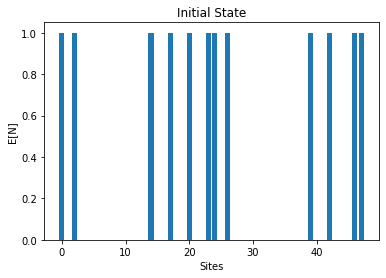

SWEEPS: 0
Sweep Left: done


ValueError: len(s)=4 not equal to leg.ind_len=3

In [254]:
#dictionary of model parameters 
model_params = {
    'bc_MPS' : 'finite',          #boundary conditions for MPS
    'conserve' : 'N',             #what should be conserved
    'filling' : 1/4,              #float, average filling
    'L' : 48,                     #length of the Chain
    'n_max' : 1,                  #maximum number of bosons per site
    't' : 1,                      #tunnelling rate
    'V' : 6,                      #potential
    'rc': 4                       #range of soft-shulder ionteraction
}


#optimize with Lanczos Algorithm
lanczos_params = {
    'cutoff':0.001,
    #'E_shift':,
    'E_tol': 1.e-10,
    #'min_gap':,
    'N_cache':10,
    #'N_max':,
    'N_min':10,
    #'P_tol':
    'reortho':True

}

#verbose dictionary
verbose = {
    'trivial_RP':False,
    'update_RP':False,
    'compute_RPs':False,
    'trivial_LP':False,
    'update_LP':False,
    'compute_LPs':False,
    'theta_ij':False,
    'Heff':False,
    'SVD':False,
    'sweep_left':False,
    'sweep_right':False,
    'DMRG':True
}

#Call DMRG algorithm
final_psi = DMRG(model_params, lanczos_params, 10, verbose)

In [ ]:
print(final_psi)

<BarContainer object of 48 artists>

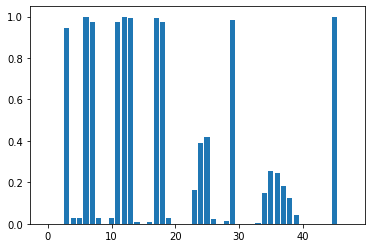

In [253]:
import matplotlib.pyplot as plt
y = final_psi.expectation_value('N')
plt.bar(range(48),y)

### Step 1b: Adaptive Restoration of MPS Form

In [289]:
Bij(0,1,psi)

<npc.Array shape=(1, 2, 2, 1) labels=['vL', 'p0', 'p1', 'vR']>

In [516]:
#split and truncate
def SVD(theta, chi_max=30, eps=1e-10):
    
    r"""

     vR*-->--Bij-->  vL*
           |   |
           ^   ^
           |   |
           p0  p1
    
    """
    
    #store dimensions
    dL, dp0, dp1, dR= theta.shape #vR* p0 p1 vL*
    
    #properly reshape theta
    theta = theta.combine_legs([['vR*','p0'],['p1','vL*']])
    print(theta.get_leg_labels())
    
    #decompose according to SVD
    X, Y, Z = svd(theta, inner_labels=['ps','ps*'],full_matrices=False) #Y is now an ndarray    
   
    
    # truncate
    #truncation dimension, minimum between chi_max and all the singular values greater than eps
    chivC = min(chi_max, np.sum(Y > eps)) 
    
    # keep the largest `chivC` singular values
    piv = np.argsort(Y)[::-1][:chivC]
    #print(piv)
    
    X, Y, Z = X[:, piv], Y[piv], Z[piv, :]

    
    # renormalize
    S = Y / np.linalg.norm(Y)  # == Y/sqrt(sum(Y**2))
    
    # split legs of X and Z
    X = X.split_legs(0)
    Z = Z.split_legs(-1)
    
    
    return X, S, Z
    
    
    
    
Ui, Sij, Vj = SVD(theta,chi_max=30, eps=1.e-10) #Sij is now an ndarray

S = np.diag(Sij) #make it a np.matrix

# create a ChargeInfo to specify the nature of the charge
chinfo = npc.ChargeInfo([1], ['N'])  # the second argument is just a descriptive name

#these might depend on the nature of the MPS
ps_charge = Vj.get_leg('ps*').charges
ps_leg = npc.LegCharge.from_qflat(chinfo, ps_charge,+1) 


#make it a npc.matrix
S = npc.Array.from_ndarray(S,[ps_leg,ps_leg.conj()], labels=['ps*','ps']) 


#reabsorb Sint Vj
M = npc.tensordot(S,Vj,axes=['ps','ps*'])


#properly replace labels
Ui = Ui.ireplace_labels([1,2],['p','vR'])
M = M.ireplace_labels([0,1],['vL','p'])

#insert into psi
psi.set_B(0,Ui)
psi.set_B(1,M)





KeyError: "Label not found: 'vR*', current labels: ['vL', 'p0', 'p1', 'vR']"